# Multivariate Time Series Forecasting

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import tensorflow as tf
from tensorflow import keras

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Air Pollution Forecasting

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

Attribute Information:

 - No    : row number
 - year  : year of data in this row
 - month : month of data in this row
 - day   : day of data in this row
 - hour  : hour of data in this row
 - pm2.5 : PM2.5 concentration (ug/m^3)
 - DEWP  : Dew Point 
 - TEMP  : Temperature
 - PRES  : Pressure (hPa)
 - cbwd  : Combined wind direction
 - Iws   : Cumulated wind speed (m/s)
 - Is    : Cumulated hours of snow
 - Ir    : Cumulated hours of rain 
 
 Ref: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## Dataset preparation

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], 
                      index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


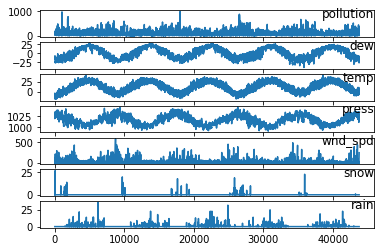

In [3]:
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [4]:
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


### Now you have X and y, slice them into training and test dataset.

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
Xtrain, Ytrain = train[:, :-1], train[:, -1]
Xtest, Ytest = test[:, :-1], test[:, -1]

### RNN needs 3D input
# reshape input to be 3D [samples, timesteps, features]
Xtrain = Xtrain.reshape((Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


## GRU RNN

In [7]:
gruModel = keras.models.Sequential()

gruModel.add(keras.layers.GRU(50, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))

gruModel.add(keras.layers.Dense(1))

gruModel.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8850      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,901
Trainable params: 8,901
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Configure  the model for training, by using appropriate optimizers and regularizations
# Available optimizer: adam, rmsprop, adagrad, sgd
# loss:  objective that the model will try to minimize. 
# Available loss: categorical_crossentropy, binary_crossentropy, mean_squared_error
# metrics: List of metrics to be evaluated by the model during training and testing. 

gruModel.compile(loss='mae', optimizer='adam', metrics=['mae'])

In [9]:
# train the model

history = gruModel.fit(Xtrain, Ytrain, epochs = 50, batch_size=72, validation_split=0.1, verbose=1 )

Train on 7884 samples, validate on 876 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
7884/7884 [==============================] - 3s 351us/sample - loss: 0.0525 - mean_absolute_error: 0.0525 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308
Epoch 2/50
7884/7884 [==============================] - 1s 108us/sample - loss: 0.0193 - mean_absolute_error: 0.0193 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153
Epoch 3/50
7884/7884 [==============================] - 1s 135us/sample - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142
Epoch 4/50
7884/7884 [==============================] - 1s 125us/sample - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0150 - val_mean_absolute_error: 0.0150
Epoch 5/50
7884/7884 [==============================] - 1s 116us/sample - loss: 0.0148 - mean_absolute_error: 0.0148 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142
Epoch 6/5

Epoch 47/50
7884/7884 [==============================] - 1s 109us/sample - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0135 - val_mean_absolute_error: 0.0135
Epoch 48/50
7884/7884 [==============================] - 1s 104us/sample - loss: 0.0141 - mean_absolute_error: 0.0141 - val_loss: 0.0135 - val_mean_absolute_error: 0.0135
Epoch 49/50
7884/7884 [==============================] - 1s 105us/sample - loss: 0.0141 - mean_absolute_error: 0.0141 - val_loss: 0.0135 - val_mean_absolute_error: 0.0135
Epoch 50/50
7884/7884 [==============================] - 1s 163us/sample - loss: 0.0142 - mean_absolute_error: 0.0142 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142


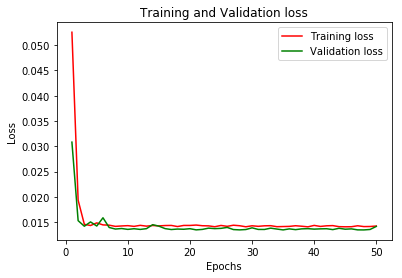

In [10]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [11]:
testResult = gruModel.evaluate(Xtest, Ytest)
print(testResult)

35039/35039 [==============================] - 2s 54us/sample - loss: 0.0133 - mean_absolute_error: 0.0133
[0.013342687144674903, 0.013342683]


# Exercise 

Modify the code as per the below instructions
- Use a different dataset.
- Choose a different embedding like word2vec or gensim, if applicable.
- Modify the architecture, as below
    - Single layer of GRU and FC
    - Two layers of GRU and FC
- Change the number of GRU units in each layer.
